<h2>
Basic Finance
</h2>

<p>
The Python code in this Jupyter notebook demonstrates some basic quantiative
finance code.
</p>
<p>
I have a Masters degree in Computational Finance and Risk Management from the
University of Washington.  In this Masters program we used R.  I also used
R for my Masters degree project (see
<a href="http://bearcave.com/finance/thesis_project/index.html">Value Factors Do Not Forecast Returns for S&P 500 Stocks</a>)
</p>
<p>
For a variety of reasons I am moving from R to Python.  This note book contains some of the
first steps in this journey.
</p>
<p>
The symbol ^IRX is the symbol for the 13-week t-bill, expressed as a yearly rate. This is used
as a proxy for the "risk free rate".
</p>

In [26]:
from typing import List
from pandas_datareader import data
from tabulate import tabulate
import pandas as pd
from pathlib import Path

tickers = ['gs', 'jpm', 'bac']

risk_free_asset = '^IRX'

print("Symbols: " + " ".join(sym + ' ' for sym in tickers))

Symbols: gs  jpm  bac 


<p>
Fetch adjusted daily close prices for the symbols
</p>
<p>
To avoid repeatedly accessing the data source, the close price data is written to a file in /tmp.
This file will be removed when the system is rebooted.
</p>

In [27]:
data_source = 'yahoo'

# year-month-day
start_date = '2019-01-01'
end_date = '2021-10-05'

tempRoot: str = '/tmp/'
stockFileName: str = 'banks.csv'
stockFilePath: str = tempRoot + stockFileName
stockTempPath = Path(stockFilePath)
if stockTempPath.exists():
    fileSize = stockTempPath.stat().st_size

fileSize = 0
if fileSize > 0:
    close_prices = pd.read_csv(stockFilePath, index_col='Date')
else:
    panel_data = data.DataReader(tickers, data_source, start_date, end_date)
    close_prices = panel_data['Adj Close']
    close_prices.to_csv(stockFilePath)

rfFileName = "risk_free.csv"
rfFilePath = tempRoot + rfFileName
rfTempPath = Path(rfFilePath)

fileSize = 0
if rfTempPath.exists():
    fileSize = rfTempPath.stat().st_size

if fileSize > 0:
    rf_prices = pd.read_csv(rfFilePath, index_col='Date')
else:
    panel_data = data.DataReader(risk_free_asset, data_source, start_date, end_date)
    rf_prices = panel_data['Adj Close']
    rf_prices.to_csv(rfFilePath)

<h3>
Basic time series statistics
</h3>

<h4>
Stocks
</h4>

In [28]:
print(tabulate(close_prices.describe(), headers=['Statistics', *tickers], tablefmt="fancy_grid"))

╒══════════════╤══════════╤══════════╤═══════════╕
│ Statistics   │       gs │      jpm │       bac │
╞══════════════╪══════════╪══════════╪═══════════╡
│ count        │ 696      │ 696      │ 696       │
├──────────────┼──────────┼──────────┼───────────┤
│ mean         │ 240.461  │ 117.073  │  29.9886  │
├──────────────┼──────────┼──────────┼───────────┤
│ std          │  73.6739 │  24.2521 │   6.23185 │
├──────────────┼──────────┼──────────┼───────────┤
│ min          │ 131.002  │  74.87   │  17.4691  │
├──────────────┼──────────┼──────────┼───────────┤
│ 25%          │ 190.829  │  96.6993 │  25.3222  │
├──────────────┼──────────┼──────────┼───────────┤
│ 50%          │ 204.868  │ 108.12   │  27.9751  │
├──────────────┼──────────┼──────────┼───────────┤
│ 75%          │ 290.02   │ 135.584  │  33.5886  │
├──────────────┼──────────┼──────────┼───────────┤
│ max          │ 417.661  │ 168.66   │  44.22    │
╘══════════════╧══════════╧══════════╧═══════════╛


Risk-free asset

In [29]:
print(tabulate(rf_prices.describe(), headers=['Statistics', risk_free_asset], tablefmt="fancy_grid"))

╒══════════════╤════════════╕
│ Statistics   │       ^IRX │
╞══════════════╪════════════╡
│ count        │ 692        │
├──────────────┼────────────┤
│ mean         │   0.867475 │
├──────────────┼────────────┤
│ std          │   0.966755 │
├──────────────┼────────────┤
│ min          │  -0.105    │
├──────────────┼────────────┤
│ 25%          │   0.045    │
├──────────────┼────────────┤
│ 50%          │   0.115    │
├──────────────┼────────────┤
│ 75%          │   1.9      │
├──────────────┼────────────┤
│ max          │   2.408    │
╘══════════════╧════════════╛


<h3>
Time series plot
</h3>

<AxesSubplot:xlabel='Date'>

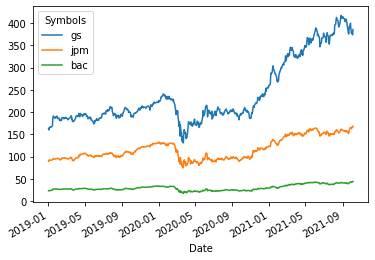

In [30]:
close_prices.plot()

<p>
The previous plot does not allow the prices of the three financial stocks to
be compared because they are on different scales.  Adjusting each stock price
so that it starts at zero allows price increases/decreases for the stocks to
be more easily compared.
</p>

<AxesSubplot:xlabel='Date'>

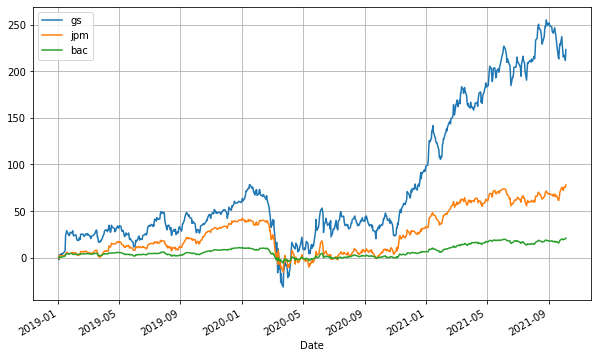

In [31]:
normalized_close_list: List = []
for sym in tickers:
    normalized = close_prices[sym] - close_prices[sym][0]
    normalized_close_list.append(normalized)

normalized_close = pd.DataFrame(normalized_close_list).transpose()

normalized_close.plot(grid=True, figsize=(10,6))

The above plot shows that Goldman Sachs (gs) is a dramatically better investment than either Bank
of America or JP Morgan.

<h3>
Sharp Ratio
</h3>

$\ sharp = \frac{E[R_a - R_{rf}]}{ \sqrt{var[R_a - R_{rf}]}}$

$\ R_a$ is the asset return
$\ R_{rf}$ is the risk free return (e.g., in this case the 13-week US Treasury bill).
$\ R_a - R_{rf}$ is the excess return over the risk free rate.

<h4>
Simple return
</h4>

$\ R = \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$
</h4>

In [32]:
def simple_return(time_series: List) -> List :
    return list(((time_series[i]/time_series[i-1]) - 1.0 for i in range(1, len(time_series))))

def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a data frame consisting of price time series, return a data frame
    that consists of the simple returns for the time series.  The returned data
    frame will have the same columns, but the time index will be one time period
    less.
    """
    r_df: pd.DataFrame = pd.DataFrame()
    col_names = time_series_df.columns
    index = time_series_df.index
    for col in col_names:
        col_vals = time_series_df[col]
        col_ret = simple_return(col_vals)
        r_df[col] = col_ret
    return r_df.set_index(index[1:len(index)])

# Number of trading days in a year
numberOfTradingDays = 253

r_df = return_df(close_prices)

<h3>
References
</h3>

<ul>
<li>LaTex References. Jupyter notebooks use LaTex markup for equations
<ul>
<li><a href="https://artofproblemsolving.com/wiki/index.php/LaTeX:Symbols">LaTex Symbols (Art of Problem Solving)</a></li>
<li><a href="https://artofproblemsolving.com/wiki/index.php/LaTeX:Commands">LaTex Commands (Art of Problem Solving)</a></li>
</ul>
</li>

</ul>
